
Found 5 run files in ./results/sgld/NA_scale1.0_lr0.0001_H1200_bs100
Valid runs with samples: 5/5

Analyzing Run ID: 0 from a total of 5 runs.

Calculating final test metrics for all valid runs...


Processing runs: 100%|██████████| 5/5 [01:16<00:00, 15.27s/it]



--- Aggregated Test Metrics ---
NLL    : 0.1339 ± 0.0097
ACC    : 0.9699 ± 0.0015
BRIER  : 0.0479 ± 0.0010
ECE    : 0.0141 ± 0.0006
Calculating NLL trace for ESS...


Evaluating samples: 100%|██████████| 1500/1500 [00:12<00:00, 118.42it/s]



--- MCMC Diagnostics (from first run) ---
Effective Sample Size (ESS) on validation NLL: 2.87 / 1500


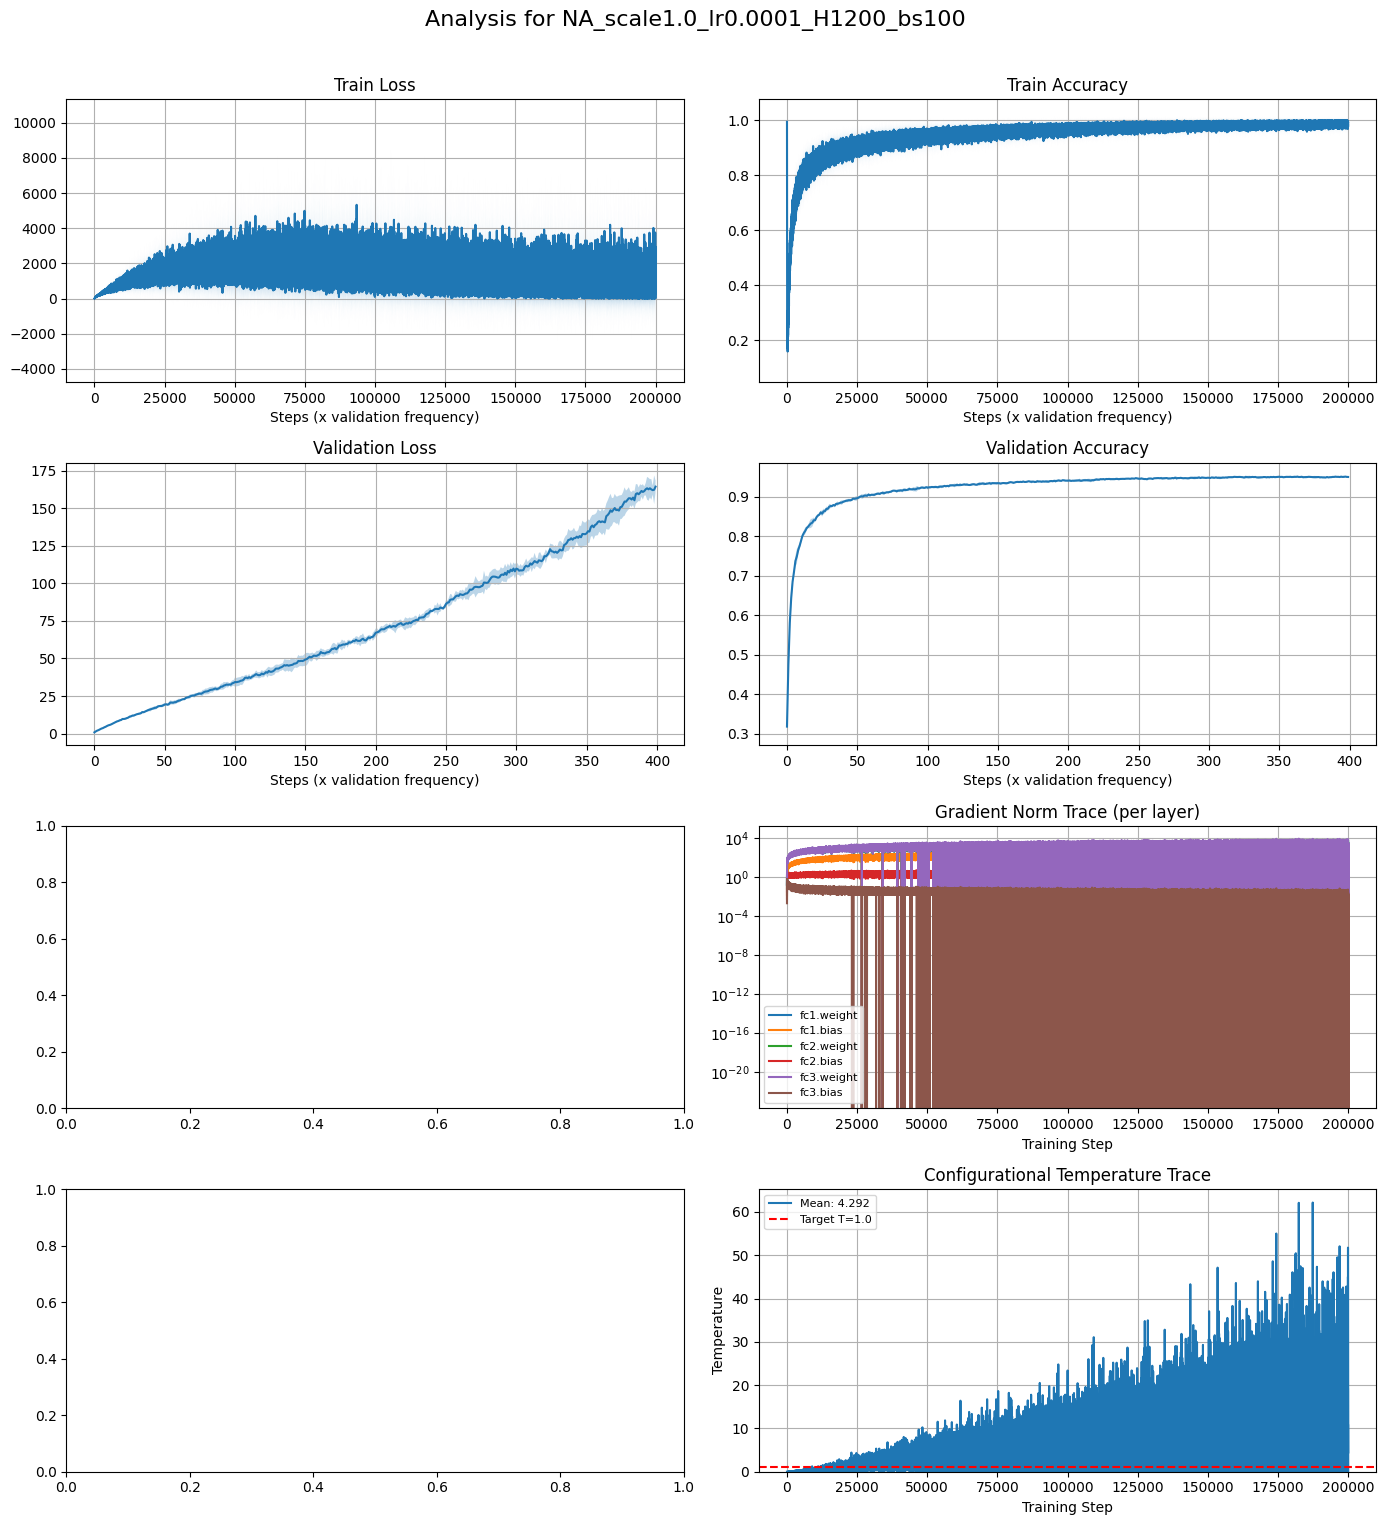

In [3]:
import os
import json
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from utils import mean_confidence_interval, set_seed
from models import MLP
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# ------------------------
# Config
# ------------------------
results_dir = "./results"
confidence = 0.95

# Option 1: Specify experiment folder path directly
experiment_folder = "./results/sgld/NA_scale1.0_lr0.0001_H1200_bs100" # Set to a path like "./results/sgld/..." or leave as None to auto-select
# Option 2: Set to None to manually select from available experiments
# experiment_folder = None

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------
# Helper Functions for Analysis
# ------------------------

# --- MODIFICATION START: Added helper functions back ---
def _expected_calibration_error(y_pred_probs, y_true, n_bins=15):
    confidences = np.max(y_pred_probs, axis=1)
    predictions = np.argmax(y_pred_probs, axis=1)
    accuracies = (predictions == y_true).astype(float)
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

def predictive_metrics_from_weight_dicts(model_class, weight_dicts, dataloader, device="cpu", psi_history=None):
    if not weight_dicts:
        raise ValueError("No samples provided for evaluation")
    
    sample_weights = np.ones(len(weight_dicts), dtype=np.float64) / len(weight_dicts)
    
    all_x = torch.cat([xb for xb, _ in dataloader], dim=0).to(device)
    all_y = torch.cat([yb for _, yb in dataloader], dim=0).numpy()
    
    model = model_class().to(device).eval()
    all_probs_weighted = None
    
    with torch.no_grad():
        for i, w in enumerate(weight_dicts):
            model.load_state_dict(w)
            logits = model(all_x)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            
            weighted_probs = sample_weights[i] * probs
            if all_probs_weighted is None:
                all_probs_weighted = weighted_probs
            else:
                all_probs_weighted += weighted_probs
    
    eps = 1e-12
    nll = float(-np.mean(np.log(all_probs_weighted[np.arange(len(all_y)), all_y] + eps)))
    acc = float((np.argmax(all_probs_weighted, axis=1) == all_y).mean())
    n_classes = all_probs_weighted.shape[1]
    onehot = np.eye(n_classes)[all_y]
    brier = float(np.mean(np.sum((all_probs_weighted - onehot) ** 2, axis=1)))
    ece = float(_expected_calibration_error(all_probs_weighted, all_y, n_bins=15))
    
    return {"nll": nll, "acc": acc, "brier": brier, "ece": ece}
# --- MODIFICATION END ---


def calculate_ess(trace, max_lag=None):
    """
    Calculate the Effective Sample Size (ESS) of a time series.
    """
    if len(trace) < 2:
        return 0.0
    
    n = len(trace)
    if max_lag is None:
        max_lag = n - 1

    mean = np.mean(trace)
    gamma = np.zeros(max_lag)
    
    for t in range(max_lag):
        gamma[t] = np.sum((trace[:n-t] - mean) * (trace[t:] - mean)) / n

    rho_sum = 0
    for t in range(1, max_lag - 1, 2):
        if gamma[t] + gamma[t+1] > 0:
            rho_sum += (gamma[t] + gamma[t+1]) / (gamma[0])
        else:
            break
            
    tau = 1 + 2 * rho_sum
    if tau <= 0: return 0.0
    ess = n / tau
    return ess

def get_nll_trace(model_lambda, samples, dataloader, device):
    """
    Calculate the negative log-likelihood for each sample on a given dataset.
    """
    print("Calculating NLL trace for ESS...")
    model = model_lambda().to(device).eval()
    nll_trace = []
    
    all_x = torch.cat([xb for xb, _ in dataloader], dim=0).to(device)
    all_y = torch.cat([yb for _, yb in dataloader], dim=0).to(device)

    with torch.no_grad():
        for s in tqdm(samples, desc="Evaluating samples"):
            model.load_state_dict(s)
            logits = model(all_x)
            nll = F.cross_entropy(logits, all_y, reduction='mean').item()
            nll_trace.append(nll)
    return np.array(nll_trace)


# ------------------------
# Find and select experiment
# ------------------------
if experiment_folder is None:
    available_experiments = []
    for sampler in os.listdir(results_dir):
        sampler_path = os.path.join(results_dir, sampler)
        if os.path.isdir(sampler_path) and not sampler.startswith('.'):
            for exp in os.listdir(sampler_path):
                exp_path = os.path.join(sampler_path, exp)
                if os.path.isdir(exp_path):
                    available_experiments.append(exp_path)

    if not available_experiments:
        raise ValueError(f"No experiment folders found in {results_dir}")

    print("Available experiments:")
    for i, exp in enumerate(available_experiments):
        print(f"  [{i}] {exp}")

    choice = int(input(f"Select experiment [0-{len(available_experiments)-1}]: ") or 0)
    experiment_folder = available_experiments[choice]
    print(f"\nUsing: {experiment_folder}")
else:
    if not os.path.exists(experiment_folder):
        raise ValueError(f"Experiment folder not found: {experiment_folder}")

# ------------------------
# Load runs
# ------------------------
run_paths = sorted(glob(os.path.join(experiment_folder, "*.pt")))
if not run_paths:
    raise ValueError(f"No .pt files found in {experiment_folder}")

print(f"\nFound {len(run_paths)} run files in {experiment_folder}")
runs = [torch.load(p, map_location="cpu") for p in run_paths]
valid_runs = [r for r in runs if "samples" in r and len(r["samples"]) > 0]
print(f"Valid runs with samples: {len(valid_runs)}/{len(runs)}")
if not valid_runs:
    raise ValueError("No valid runs with samples to analyze.")

# ------------------------
# Prepare for Analysis
# ------------------------
main_run = valid_runs[0]
cfg = main_run['config']
print(f"\nAnalyzing Run ID: {cfg.get('run_id', 0)} from a total of {len(valid_runs)} runs.")

set_seed(cfg.get('seed', 42))
transform = transforms.Compose([transforms.ToTensor()])
trainval = datasets.MNIST(root="data", train=True, download=True, transform=transform)
testset = datasets.MNIST(root="data", train=False, download=True, transform=transform)
_, val_set = random_split(trainval, [50000, 10000])
val_loader = DataLoader(val_set, batch_size=500, shuffle=False)
test_loader = DataLoader(testset, batch_size=500, shuffle=False)
model_lambda = lambda: MLP(hidden=cfg['hidden'])


# --- MODIFICATION START: Calculate and print aggregated final test metrics ---
# ------------------------
# Aggregate Final Test Metrics
# ------------------------
print("\nCalculating final test metrics for all valid runs...")
all_metrics = {'nll': [], 'acc': [], 'brier': [], 'ece': []}
for run in tqdm(valid_runs, desc="Processing runs"):
    metrics = predictive_metrics_from_weight_dicts(
        model_class=model_lambda,
        weight_dicts=run['samples'],
        dataloader=test_loader,
        device=device
    )
    for key in all_metrics:
        all_metrics[key].append(metrics[key])

print("\n--- Aggregated Test Metrics ---")
for key, values in all_metrics.items():
    mean = np.mean(values)
    if len(values) > 1:
        _, ci = mean_confidence_interval(values, confidence=confidence)
        print(f"{key.upper():<7}: {mean:.4f} ± {ci:.4f}")
    else:
        print(f"{key.upper():<7}: {mean:.4f} (single run)")
# --- MODIFICATION END ---


# ------------------------
# Calculate ESS
# ------------------------
nll_trace = get_nll_trace(model_lambda, main_run['samples'], val_loader, device)
ess = calculate_ess(nll_trace)
print("\n--- MCMC Diagnostics (from first run) ---")
print(f"Effective Sample Size (ESS) on validation NLL: {ess:.2f} / {len(main_run['samples'])}")

# ------------------------
# Process data for plots
# ------------------------
history_keys = ["train_loss", "train_acc", "val_loss", "val_acc"]
agg_curves = {}
for key in history_keys:
    min_len = min(len(r["train_val_history"][key]) for r in valid_runs)
    aligned = np.array([r["train_val_history"][key][:min_len] for r in valid_runs])
    mean, ci = mean_confidence_interval(aligned, confidence)
    agg_curves[key] = {"mean": mean, "ci": ci}

dt_hist = main_run.get("dt_history", [])
dt_traces = {name: [s.get(name, 0) for s in dt_hist] for name in dt_hist[0]} if dt_hist else {}

grad_norm_hist = main_run.get("grad_norm_history", [])
grad_norm_traces = {name: [s.get(name, 0) for s in grad_norm_hist] for name in grad_norm_hist[0]} if grad_norm_hist else {}

z_hist = main_run.get("z_history", [])
z_traces = {name: [s.get(name, 0) for s in z_hist] for name in z_hist[0]} if z_hist else {}

config_temp_hist = main_run.get("config_temp_history", [])

# ------------------------
# Combined figure: 4x2 grid
# ------------------------
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
fig.suptitle(f"Analysis for {os.path.basename(experiment_folder)}", fontsize=16)

# === Top 2 rows: Training curves ===
titles = ["Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"]
for ax, key, title in zip(axes[:2, :].flatten(), history_keys, titles):
    mean, ci = agg_curves[key]["mean"], agg_curves[key]["ci"]
    steps = np.arange(len(mean))
    ax.plot(steps, mean)
    ax.fill_between(steps, mean - ci, mean + ci, alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel("Steps (x validation frequency)")
    ax.grid(True)

# === Row 3: Step-size and Gradient Norm Traces ===
if dt_traces:
    ax = axes[2, 0]
    for name, trace in dt_traces.items():
        ax.plot(trace, label=name)
    ax.set_title("Step-size Trace (per layer)")
    ax.set_xlabel("Training Step")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend(fontsize=8)

if grad_norm_traces:
    ax = axes[2, 1]
    for name, trace in grad_norm_traces.items():
        ax.plot(trace, label=name)
    ax.set_title("Gradient Norm Trace (per layer)")
    ax.set_xlabel("Training Step")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend(fontsize=8)
    
# === Row 4: Z Trace and Configurational Temperature ===
if z_traces:
    ax = axes[3, 0]
    for name, trace in z_traces.items():
        ax.plot(trace, label=name)
    ax.set_title("Z Trace (per layer)")
    ax.set_xlabel("Training Step")
    ax.grid(True)
    ax.legend(fontsize=8)
    
if config_temp_hist:
    ax = axes[3, 1]
    ax.plot(config_temp_hist, label=f"Mean: {np.mean(config_temp_hist):.3f}")
    ax.axhline(cfg['temperature'], color='r', linestyle='--', label=f"Target T={cfg['temperature']}")
    ax.set_title("Configurational Temperature Trace")
    ax.set_xlabel("Training Step")
    ax.set_ylabel("Temperature")
    ax.set_ylim(bottom=0) # Temperature cannot be negative
    ax.grid(True)
    ax.legend(fontsize=8)
else:
    axes[3, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Load initial optimizer

In [3]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Assumed to be in your project structure and accessible ---
from models import MLP
from eval import predictive_metrics_from_weight_dicts

# --- Configuration ---
checkpoint_path = "initial/prior_NA_lr_0.1_H_1200.pt"
hidden_units = 1200
batch_size = 500
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Setup Dataloader ---
def get_test_loader(batch_size):
    transform = transforms.Compose([transforms.ToTensor()])
    test_set = datasets.MNIST(root="data", train=False, download=True, transform=transform)
    return DataLoader(test_set, batch_size=batch_size, shuffle=False)

    
# Load data and define how to build the model
test_loader = get_test_loader(batch_size)
model_constructor = lambda: MLP(hidden=hidden_units)

# Load the state dictionary from your saved file
state_dict = torch.load(checkpoint_path, map_location="cpu")

# Wrap the state_dict in a list for the evaluation function
weight_dicts = [state_dict]

print(f"\nComputing metrics for: {checkpoint_path}...")

# Compute metrics using the eval function
metrics = predictive_metrics_from_weight_dicts(
    model_class=model_constructor,
    weight_dicts=weight_dicts,
    dataloader=test_loader,
    device=device,
    psi_history=None
)

print("\n--- ✅ Final Evaluation Metrics ---")
for key, val in metrics.items():
    print(f"  {key.upper():<7}: {val:.4f}")


Computing metrics for: initial/prior_NA_lr_0.1_H_1200.pt...

--- ✅ Final Evaluation Metrics ---
  NLL    : 0.0740
  ACC    : 0.9814
  BRIER  : 0.0298
  ECE    : 0.0108
